train acc, test acc =  0.09751666666666667 0.0974
train acc, test acc =  0.09751666666666667 0.0974
train acc, test acc =  0.09751666666666667 0.0974
train acc, test acc =  0.09751666666666667 0.0974
train acc, test acc =  0.09751666666666667 0.0974
train acc, test acc =  0.09751666666666667 0.0974
train acc, test acc =  0.09751666666666667 0.0974
train acc, test acc =  0.09751666666666667 0.0974
train acc, test acc =  0.09751666666666667 0.0974
train acc, test acc =  0.09751666666666667 0.0974
train acc, test acc =  0.09751666666666667 0.0974
train acc, test acc =  0.09751666666666667 0.0974
train acc, test acc =  0.09751666666666667 0.0974
train acc, test acc =  0.09751666666666667 0.0974
train acc, test acc =  0.09751666666666667 0.0974
train acc, test acc =  0.09751666666666667 0.0974
train acc, test acc =  0.09751666666666667 0.0974


ValueError: x and y must have same first dimension, but have shapes (1,) and (17,)

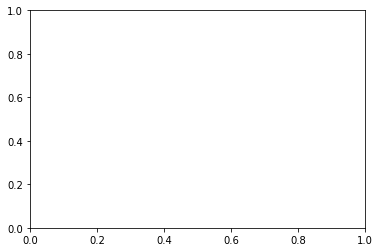

In [8]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pylab as plt
from dataset.mnist import load_mnist

def sigmoid(x) :
    return 1 / (1 + np.exp(-x))

def softmax(a) :
    c = np.max(a) # 오버플로 방지용, 소프트맥스 함수의 지수 함수를 계산할 때 어떤 정수를 더해도 결과는 안 바뀌니 입력 신호 중 최댓값을 이용
    exp_a = np.exp(a-c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    
    return y

# 오차제곱합(손실 함수), 오차제곱합 함수를 거쳐 나온 값이 작을 수록(0에 인접할 수록) 정답일 확률이 높다
def sum_squares_error(y, t):
    return 0.5 * np.sum((y-t)**2)

# 교차 엔트로피 오차(손실 함수), 정답일 때의 출력이 전체 값을 정하게 되며 함수를 거쳐 나온 값이 작을 수록(0에 인접할 수록) 정답일 확률이 높다.
def cross_entropy_error(y, t):
    # y는 신경망의 출력, t는 정답 레이블
    """
    일반 교차 엔트로피 오차 함수
    delta = 1e-7 # 아주 작은 값
    return -np.sum(t * np.log(y + delta)) # np.log() 함수에 0입 입력하면 -inf(마이너스 무한대)가 나오므로 아주작은 값 delta를 더한 것
    """
    # 배치 데이터(미니배치 학습 같을 때 쓰이는 입력 데이터의 묶음 데이터)를 지원하는 교차 엔트로피 오차 함수
    if y.ndim == 1: # 신경망의 출력이 1차원(데이터 하나당 교차 엔트로피 오차 구하는 경우)이라면 reshape 함수로 데이터의 형상 바꾸기
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    # 정답 레이블이 원-핫 인코딩이 아니라 숫자 레이블 같이 주어졌을 때는 return -np.sum(np.log(y[np.arrange(batch_size), t] + 1e-7))/batch_size 로 리턴값 넘겨준다.
    return -np.sum(t * np.log(y + 1e-7))/batch_size # 원-핫 인코딩일 때는 t가 0인 원소는 교차 엔트로피 오차도 0이라 그 계산은 무시한다.

# 수치 미분 함수, 아주 작은 차분으로 미분 하는 것을 '수치 미분'이라 한다. -> 일반 수학시간에 배우는 미분을 근사치로 계산하는 방법
def numerical_diff(f ,x):
    h = 1e-4 # 0.0001, 이 값을 이용하면 반올림 오차 문제(작은 값이 생략되어 결과에 오차가 생기는 것)를 예방하면서 좋은결과를 얻는다고 알려짐
    return (f(x+h)-f(x-h))/(2*h) # 중심 차분 or 중앙 차분 방법, x를 중심으로 h만큼 차분 계산한다는 것 / 이 외에도 x+h와 x 같은 전방 차분도 있다.

# 기울기 함수, 모든 변수의 편미분을 벡터로 정리한 것 f는 함수, x는 넘파이 배열 구해지는 기울기로 손실 함수의 최솟값을 찾아야 한다.
# 기울기가 가리키는 방향이 0에 가깝게 해당 함수의 기울기를 조절하는 방향이다. 대표적인 방법으로 경사 하강법(최솟값 찾을 때)이 있다. [반대 되는 개념으로 최댓값을 찾는 경사 상승법이 있다.]
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x[0].size):
        tmp_val = x[idx]
        
        #f(x+h) 계산
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        #f(x-h) 계산
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        
    return grad

# 경사 하강법 함수, init_x는 초깃값, lr은 학습률(하이퍼파라미터, 매개변수(가중치 등) 값을 얼마나 갱신할 지, 너무 작거나 크면 안된다.)
# step_num은 경사법에 따른 반복 횟수를 의미한다. 경사 하강법 함수는 최솟값을 찾는 함수이다.
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    
    for i in range(step_num): # 기울기에 학습률을 곱한 값으로 갱신하는 처리는 step_num번 한다
        grad = numerical_gradient(f, x) # 함수의 기울기 구하기
        x -= lr * grad
        
    return x

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01): # 입력층 뉴런수, 은닉층 뉴런수, 출력층 뉴런수
        #가중치 초기화
        self.params = {} # 해당 신경망의 매개변수(가중치, 편향)를 보관하는 사전 변수
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x,W1)+b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1,W2)+b2
        y = softmax(a2)
        
        return y
    
    # x: 입력 데이터, t: 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum( y == t)/float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {} # 기울기를 저장하는 사전 변수
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# 하이퍼파라미터들, 수정은 수동(사람의 손으로)으로 해야한다
iters_num = 10000 # 반복 횟수
train_size = x_train.shape[0]
batch_size = 100 # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# '1'에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)
    
    # 매개변수(가중치, 편향) 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # '1'에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc = ", train_acc, test_acc)
      
plt.plot(iter_per_epoch, train_acc_list, label="train_acc")
plt.plot(iter_per_epoch, test_acc_list, linestyle="--", label="test_acc")
plt.xlabel("Accuracy")
plt.ylabel("Epoch")
plt.legend()
plt.show()